In [1]:
import sys
print(sys.path)
sys.path.append('/home/mye/FP/tutorials/code/promp')


import os
import argparse
import random 

import numpy as np
import pickle
import tensorflow as tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from IPython import display

from data_loader import integral, DataLoader, differentiate, numpy_fillzeros
from model import Model
from promp.kl_eval import kl_demo, kl_divergence

['', '/home/mye/tools/anacondas3/envs/python2/lib/python27.zip', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/plat-linux2', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/lib-tk', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/lib-old', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/lib-dynload', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/site-packages', '/home/mye/tools/anacondas3/envs/python2/lib/python2.7/site-packages/IPython/extensions', '/home/mye/.ipython']


In [2]:
def main():
  parser = argparse.ArgumentParser()
  parser.add_argument('--filename', type=str, default='sample',
                     help='filename to save the output')
  parser.add_argument('--sample_length', type=int, default=300,
                     help='number of strokes to sample')
  parser.add_argument('--model_dir', type=str, default='checkpoints',
                     help='directory to load model from')
  parser.add_argument('--bias', type=float, default=0.,
                     help='a non-negative float to restrict the '
                          'sampling process.')
  parser.add_argument('--touch_dist', type=float, default=0.03,
                     help='a positive float to indicate the touch '
                          'distance of two objects')
  parser.add_argument('--stop_spd', type=float, default=0.05,
                     help='a positive float to indicate the max. '
                          'allowed speed for reaching.')
  
  args = parser.parse_args(['--sample_length', '300'])

  evaluate(args)

In [2]:




# def eval_traj(traj, obstacle, target, touch_dist=0.03, stop_spd=0.05):
#   """ To check if a specific trajectory succeeded, there are 3 conditions
#           to define a successful trajectory: 1) reach the target, while
#           2) reach with a small velocity, and 3) avoid the obstacle.

#       inputs:
#         traj: [time, DoF*joints], the generated trajectory
#         obstacle: [time, DoF*joints], the obstacle trajectory
#         target: [DoF*joints], the target position
#         touch_dist: float, the threshold to judge if the target is reached. Also
#           used for checking if the obstacle is hit.
#         stop_spd: float, the maximal allowed speed to accept a successful 
#           reaching. If the object reaches the target but only with a speed higher
#           than stop_spd, it will be rejected as a failure.
#       returns:
#         success: bool
#         dist_target_min: float, if success, return the minimal distance to target 
#           within acceptable velocity, otherwise minimal distance to target
#         traj_ends_at: if success, return the index of first valid reaching point
#   """
#   dist_target = np.sqrt(np.sum((target - traj) ** 2., axis=1)) # [time]
#   vel, _ = differentiate(traj, 8. / 250.)
#   vel_amplitude = np.sqrt(np.sum(vel ** 2., axis=1))
#   dist_obstacle = np.sqrt(np.sum((obstacle - traj) ** 2., axis=1))

#   dist_in_range = map(lambda x: x < touch_dist, dist_target)
#   obstacle_hit = map(lambda x: x < touch_dist, dist_obstacle)

#   if any(dist_in_range):
#     vel_in_range = map(lambda v: v < stop_spd, vel_amplitude)
#     dists = [ dist_target[i] for i in range(len(traj)) 
#               if dist_in_range[i] and vel_in_range[i] ]
#     if dists:
#       traj_ends_at = np.argmin(dist_target)
#       # target reached, velocity in safe range
#       return not any(obstacle_hit[:traj_ends_at]), min(dists), traj_ends_at

#   return False, min(dist_target), len(dist_target)

def eval_traj(traj, obstacle, target, threshold=0.03):
  """ This is required by Ben Pfirrman for project consistancy
  """
  distance = np.sqrt(np.sum(np.square(target - traj), axis=1))
  # print(distance[-5:])
  return distance[-1] < 0.03, None, len(traj)

def fill_trajs(trajs, max_len):
  res = []
  dof = trajs[0].shape[1]
  for t in trajs:
    assert t.shape[0] <= max_len
    tail = np.repeat(t[-1:, :], max_len - t.shape[0], axis=0)
    new = np.concatenate((t, tail), axis=0)
    res.append(new)
  return np.array(res)

def eval_kmeans(trajs, true_trajs, labels, max_len=200):
  # evaluate the trajectory with kl divergence, the group is defined by labels
  trajs = fill_trajs(trajs, max_len)
  true_trajs = fill_trajs(true_trajs, max_len)
  kl1 = kl_divergence(true_trajs[labels == 0], trajs[labels == 0])
  kl2 = kl_divergence(true_trajs[labels == 1], trajs[labels == 1])
  return min(kl1, kl2), max(kl1, kl2)


def erase_padding(sequence):
  length = sequence.shape[0]
  limit = length

  for i in range(length-1, -1, -1):
    if all(sequence[i, :] == 0):
      limit = i
    else:
      break
  return sequence[:limit, :], limit


def evaluate(sample_args):
  with open(os.path.join(sample_args.model_dir, 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)
  
  # prepare test data #batch?????????
  data_loader = DataLoader(
    batch_size=20, 
    scale_factor=saved_args.data_scale, 
    subseq_length=300
    )

  # load model
  model = Model(saved_args, sampling=True, bias=sample_args.bias)
  sess = tf.InteractiveSession()
  saver = tf.train.Saver()
  ckpt = tf.train.get_checkpoint_state(sample_args.model_dir)
  print("loading model: " + ckpt.model_checkpoint_path)
  saver.restore(sess, ckpt.model_checkpoint_path)
  use_gmm = True if saved_args.loss_form == "gmm" else False
  

  ###### large quantitative evaluate: kl divergence from true dataset ###########

  for case_idx in range(1, 10):
    trajs = []
    trajs_true = []
    x, y, labels, c = data_loader.validation_data_all(case_idx) # x: (70)(var,6),c:(70)(12)
    for sample in range(len(labels)):
      obstacle = x[sample][:, 3:]
      true_acc = x[sample][:, :3] #??????? (var, 3)
      condition = c[sample]
      pos_start = condition[:3]
      spd_start = condition[3:6]
      target = condition[6:9]
      pred_acc, pred_traj = model.sample(
        sess=sess, 
        obstacle_traj=obstacle,
        conditions=condition,
        gmm=use_gmm
        )
      speed_true = integral(true_acc, spd_start, 8. / 250)
      pos_true = integral(speed_true, pos_start, 8. / 250) # (var,3)
      final_point = np.argmin(np.sum(np.square(pos_true - target), axis=1)) #Returns the indices of the minimum values along an axis.
      pos_true[final_point:, :] = pos_true[final_point, :]
      trajs.append(pred_traj)
      trajs_true.append(pos_true)
    kl1, kl2 = eval_kmeans(trajs, trajs_true, labels) #labels: 0/1??   ????????????????
    print('KL divergence for case %d, fw: %.4f, bw: %.4f'%(case_idx, kl1, kl2))


  ###### quantitative evaluate: all validation samples from each case ###########

  print("Testing validation samples from each of the cases")
  for case_idx in range(1,10):
    print("Testing case no. %d" % case_idx)
    x, y, w, c = data_loader.validation_data_all_wo_kmeans(case_idx) # x: [70][26,6], [num_samples, subseq_length, 6/3/]
    case_success = 0
    for sample in range(len(x)):
      obstacle = x[sample, :, 3:]
      true_acc = x[sample, :, :3] 
      condition = c[sample, :]
      pos_start = condition[:3]
      spd_start = condition[3:6]
      target = condition[6:9]
      pred_acc, pred_traj = model.sample(
        sess=sess, 
        obstacle_traj=obstacle,
        conditions=condition,
        gmm=use_gmm
        )
      speed_true = integral(true_acc, spd_start, 8. / 250)
      pos_true = integral(speed_true, pos_start, 8. / 250)
      final_point = np.argmin(np.sum(np.square(pos_true - target), axis=1))
      pos_true[final_point:, :] = pos_true[final_point, :]
      # plt.plot(pos_true[:, 0], pos_true[:, 1])
      # plt.scatter(target[0], target[1], c='k')
      # plt.show()
      if sample == 10:
        with open('case%d_size%d.pkl' % (case_idx, saved_args.dim_rec), 'wb') as f:
          pickle.dump([pred_traj, pos_true], f)
      # success, _, _ = eval_traj(pred_traj, obstacle, target, 
      #                           sample_args.touch_dist,
      #                           sample_args.stop_spd)
      success, _, _ = eval_traj(pred_traj, obstacle, target)

      case_success += 1 if success else 0
    print("The number of success for case %d: %d/%d" 
          % (case_idx, case_success, len(x)))

  ####### qualitative evaluate: plot one random sample from each case ############
  x, y, w, c = data_loader.validation_data(range(1,10))
  
  for test_sample in range(9):

    cond = c[test_sample]
    obstacle = x[test_sample, :, 3:6]

    print("evaluating test sample %d/%d" % (test_sample+1, 20))
    acc_predicted, traj_predicted = model.sample(
      sess=sess, 
      obstacle_traj=obstacle,
      conditions=cond,
      gmm=use_gmm
      )
    
    pos_start = cond[:3]
    spd_start = cond[3:6]
    tar_p1 = cond[6:9]
    tar_p2 = cond[9:]

    # print(traj_predicted)

    # success, _, ends_at = eval_traj(traj_predicted, obstacle, tar_p1,
    #                                 sample_args.touch_dist,
    #                                 sample_args.stop_spd)
    success, _, ends_at = eval_traj(pred_traj, obstacle, target)
    print('Trajectory ends at %d' % ends_at)
    if success:
      print("Evaluated as success.")
    else:
      print("Evaluated as failure.")

    # naive acc plot, x axis
    plt.plot(acc_predicted[:ends_at, 0], c='r', label='predicted')
    plt.plot(y[test_sample][:ends_at, 0], c='b', label='truth')
    plt.legend()
    plt.show()

    # position plot
    acc_true, limit = erase_padding(y[test_sample])
    # acc_true = y[test_sample][:ends_at, :]
    obstacle = obstacle[:limit, :]

    # speed = integral(acc_predicted, spd_start, 0.02)
    # pos = integral(speed, pos_start, 0.02)
    pos = traj_predicted[:ends_at, ]

    speed_true = integral(acc_true, spd_start, 8. / 250)
    pos_true = integral(speed_true, pos_start, 8. / 250)

    # 2d
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca()
    ax.plot(pos_true[:, 0], pos_true[:, 1], c='b', label='truth')
    ax.plot(pos[:, 0], pos[:, 1], c='r', label='predicted')
    ax.plot(obstacle[:, 0], obstacle[:, 1], c='g', label='obstacle')
    ax.scatter(tar_p1[0], tar_p1[1], c='k', label='target')
    plt.legend()
    plt.show()

    # 3d
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    ax.plot(pos_true[:, 0], pos_true[:, 1], pos_true[:, 2], c='b')
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], c='r')
    ax.plot(obstacle[:, 0], obstacle[:, 1], obstacle[:, 2], c='g')
    ax.scatter(tar_p1[0], tar_p1[1], tar_p1[2], c='k')
    plt.show()


Maximal length of the training data is 169
Training data case distribution: [5348, 5108, 4904, 1208, 1260, 1224, 916, 1180, 1216, 1044, 876, 456, 1264, 992, 1080, 932, 1008, 420, 1160, 1036]
Validation data case distribution: [70, 67, 65, 15, 17, 16, 12, 15, 16, 14, 12, 6, 17, 13, 14, 13, 14, 5, 15, 13]
Shuffling training data...
Number of trainable variables 6
[<tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(134, 512) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_1/basic_lstm_cell/kernel:0' shape=(256, 512) dtype=float32_ref>, <tf.Variable 'rnn/multi_rnn_cell/cell_1/basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'out_W:0' shape=(128, 3) dtype=float32_ref>, <tf.Variable 'out_b:0' shape=(3,) dtype=float32_ref>]
loading model: checkpoints/model.ckpt-100
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-100
KL divergenc

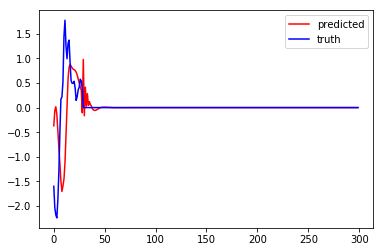

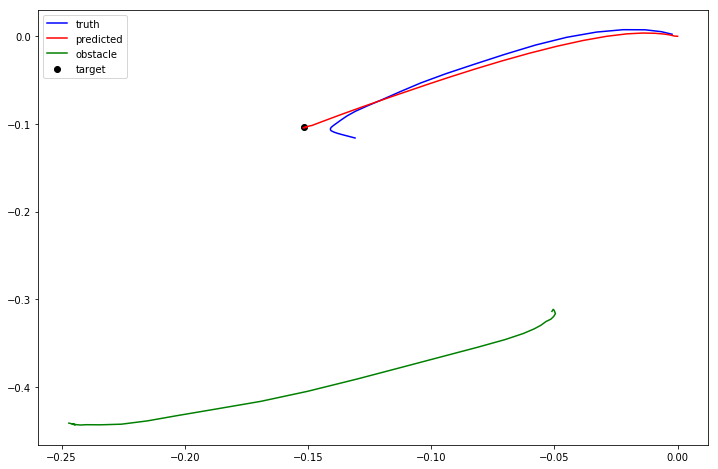

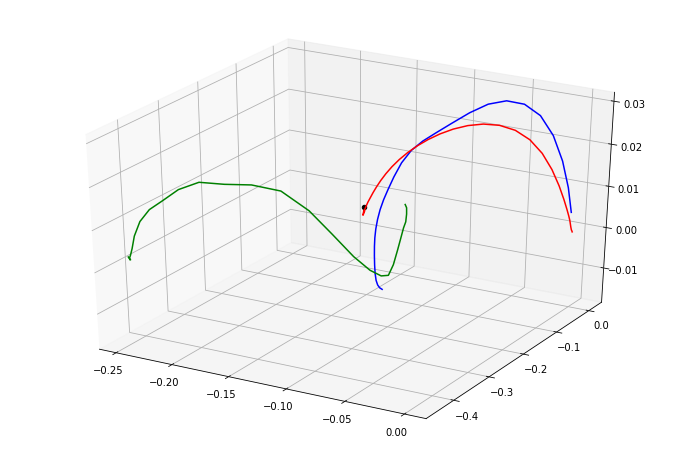

evaluating test sample 2/20
Trajectory ends at 300
Evaluated as success.


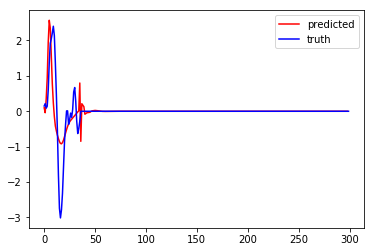

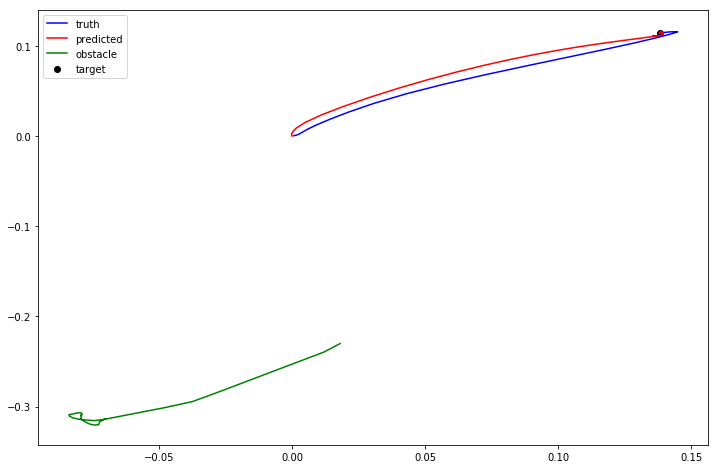

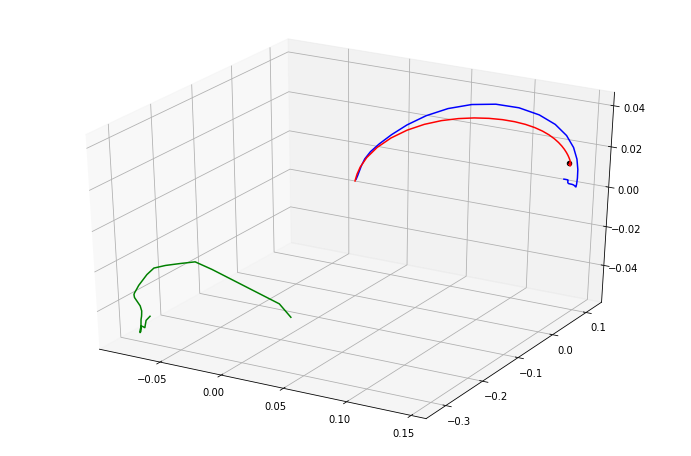

evaluating test sample 3/20
Trajectory ends at 300
Evaluated as success.


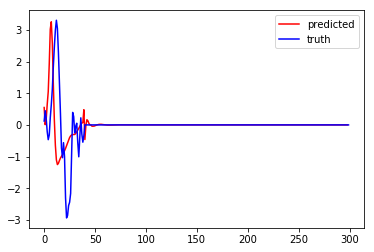

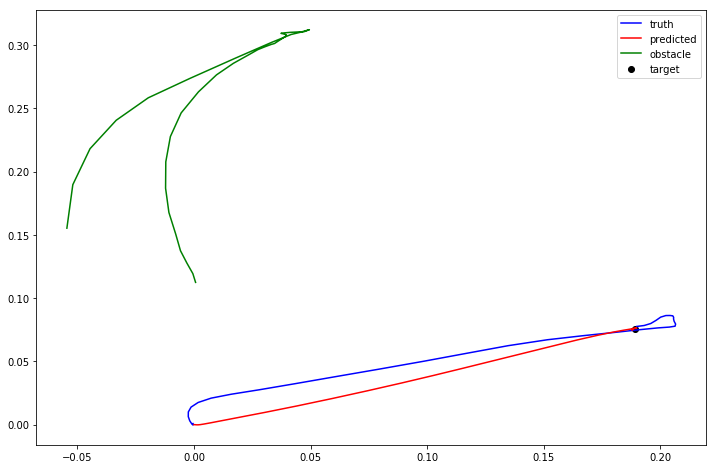

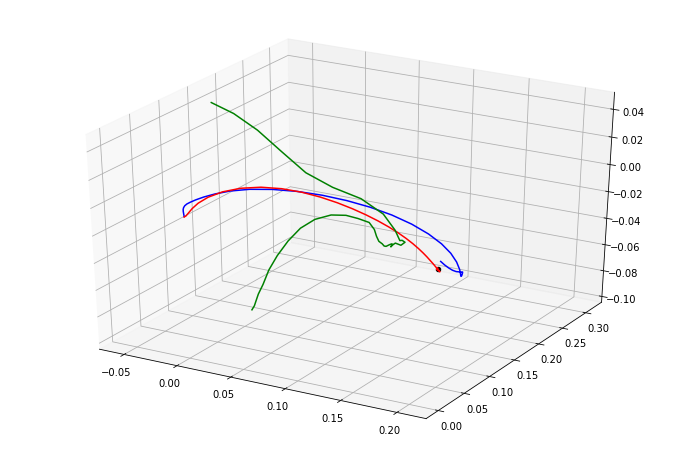

evaluating test sample 4/20
Trajectory ends at 300
Evaluated as success.


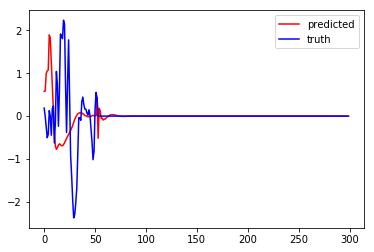

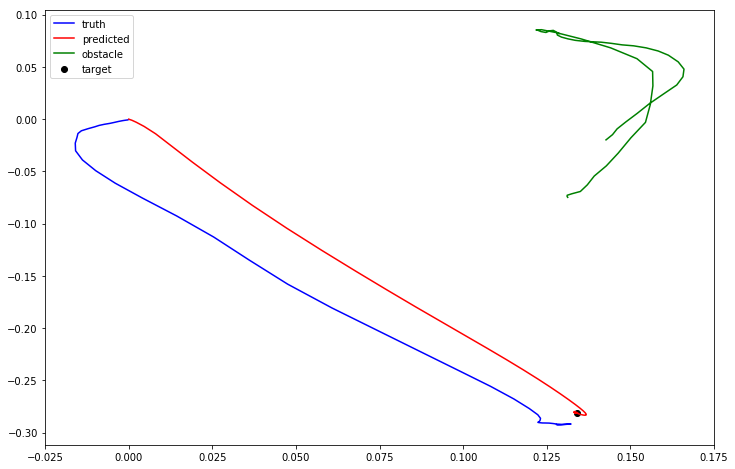

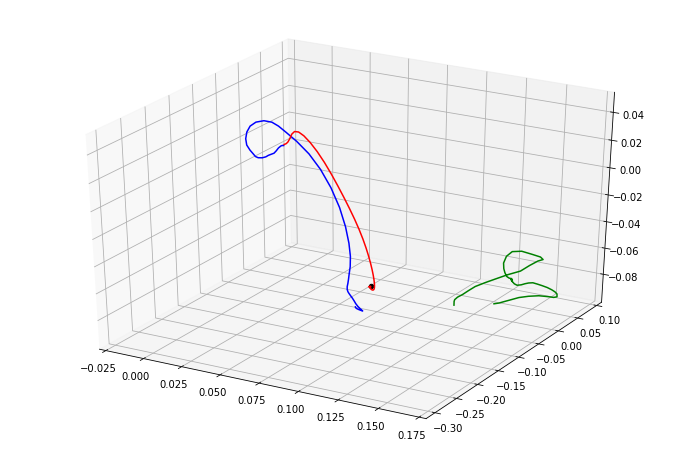

evaluating test sample 5/20
Trajectory ends at 300
Evaluated as success.


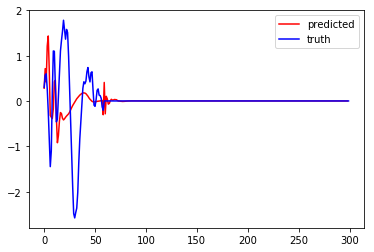

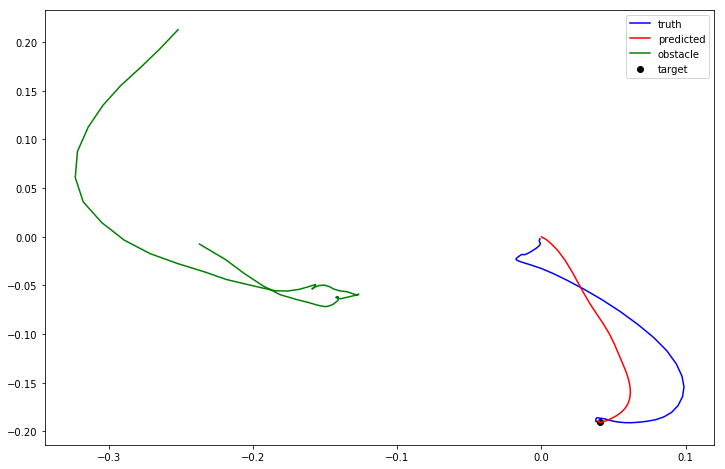

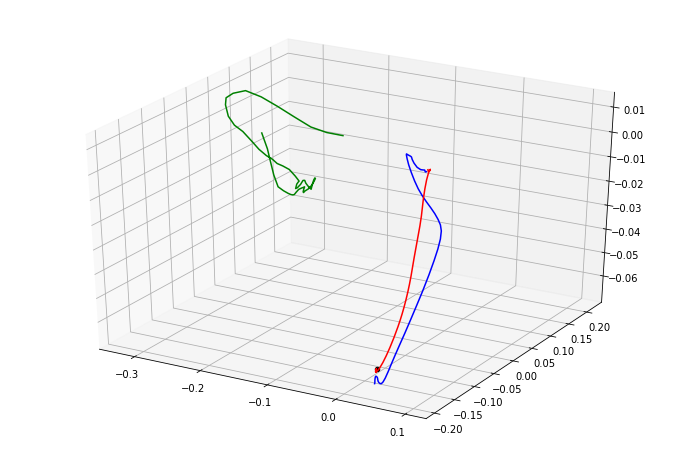

evaluating test sample 6/20
Trajectory ends at 300
Evaluated as success.


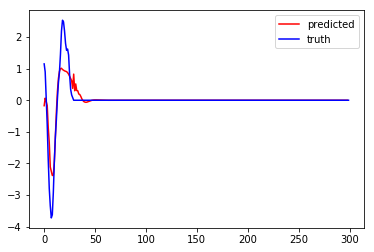

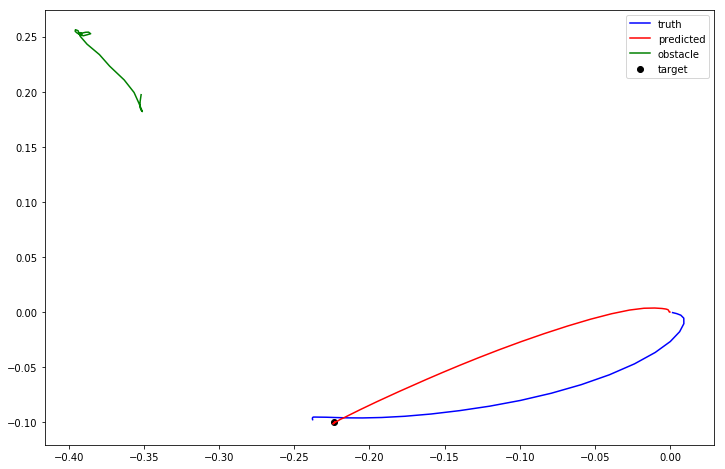

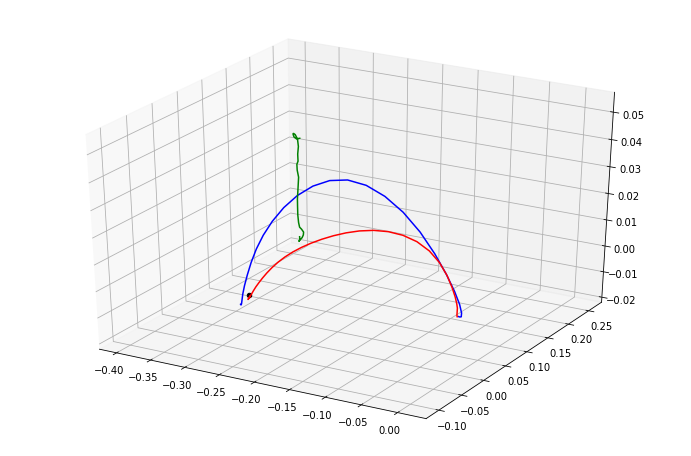

evaluating test sample 7/20
Trajectory ends at 300
Evaluated as success.


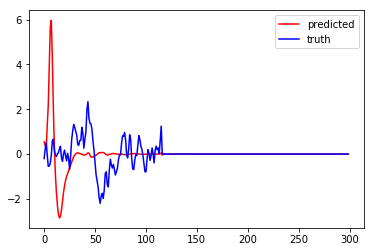

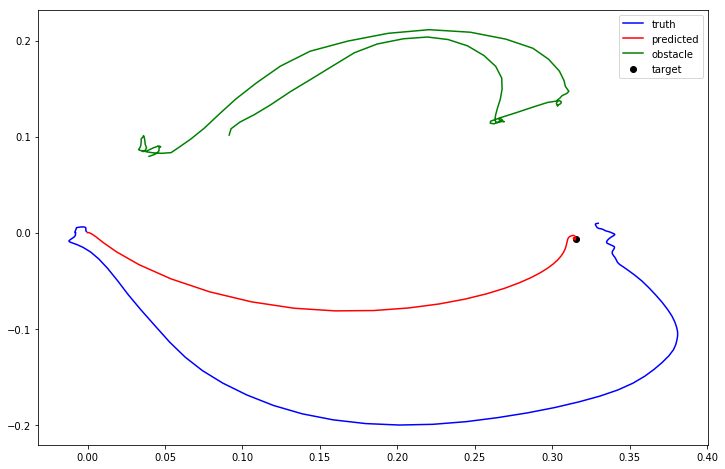

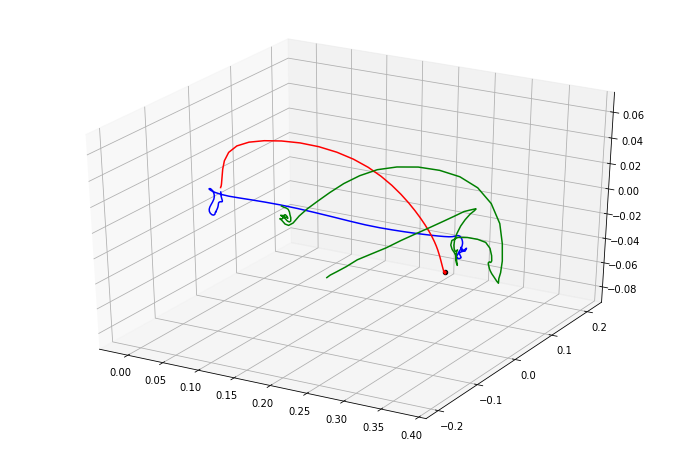

evaluating test sample 8/20
Trajectory ends at 300
Evaluated as success.


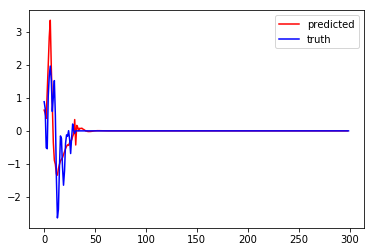

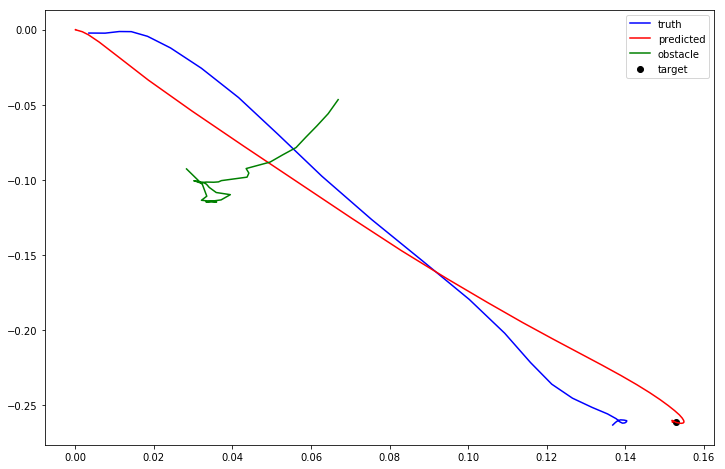

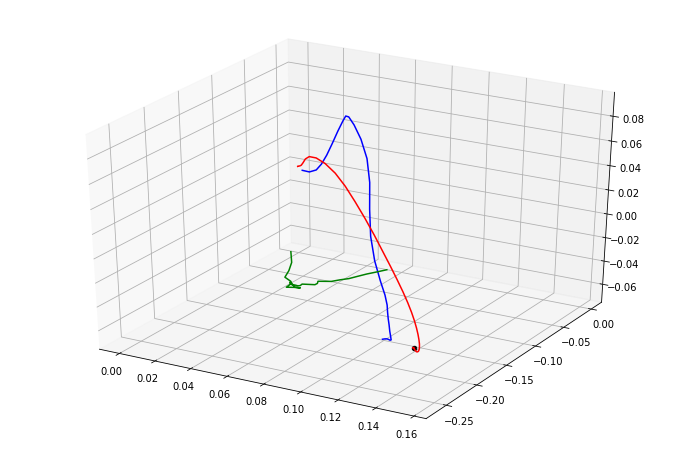

evaluating test sample 9/20
Trajectory ends at 300
Evaluated as success.


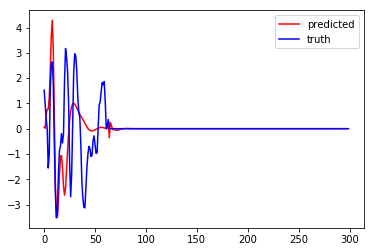

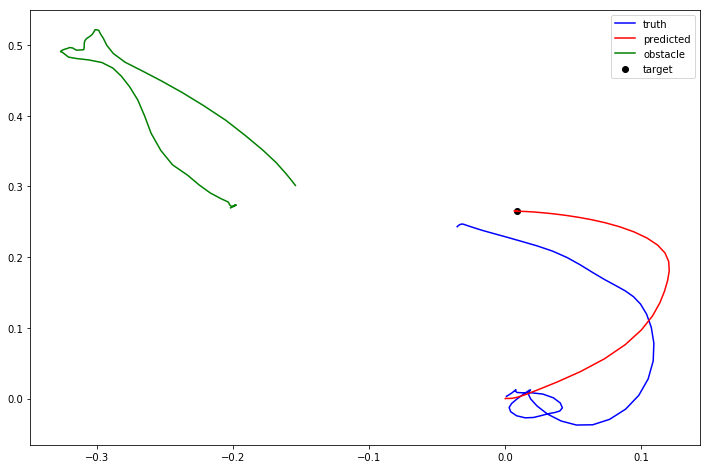

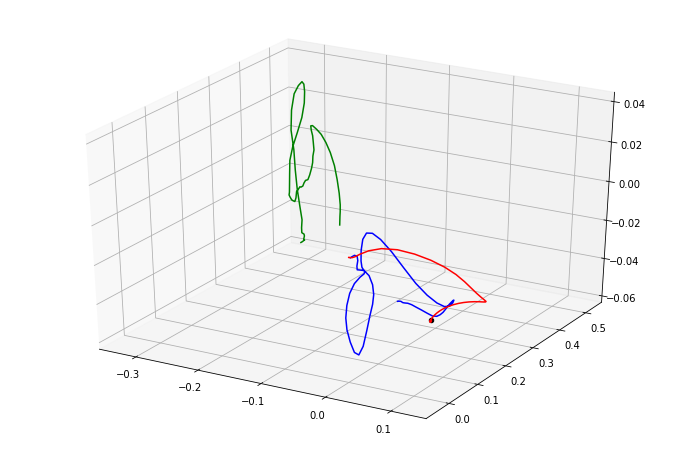

In [3]:

if __name__ == "__main__":
  main()


### 2. Alternative sample

In [26]:
  parser = argparse.ArgumentParser()
  parser.add_argument('--filename', type=str, default='sample',
                     help='filename to save the output')
  parser.add_argument('--sample_length', type=int, default=300,
                     help='number of strokes to sample')
  parser.add_argument('--model_dir', type=str, default='checkpoints',
                     help='directory to load model from')
  parser.add_argument('--bias', type=float, default=0.,
                     help='a non-negative float to restrict the '
                          'sampling process.')
  parser.add_argument('--touch_dist', type=float, default=0.03,
                     help='a positive float to indicate the touch '
                          'distance of two objects')
  parser.add_argument('--stop_spd', type=float, default=0.05,
                     help='a positive float to indicate the max. '
                          'allowed speed for reaching.')
  
  args = parser.parse_args(['--sample_length', '300'])
    
sample_args = args

In [ ]:
### Evaluate 
evaluate(sample_args)

## Test

In [28]:

sample_args = args

with open(os.path.join(sample_args.model_dir, 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)

    

data_loader = DataLoader(
    batch_size=20, 
    scale_factor=saved_args.data_scale, 
    subseq_length=300
    )

Maximal length of the training data is 169
Training data case distribution: [5348, 5108, 4904, 1208, 1260, 1224, 916, 1180, 1216, 1044, 876, 456, 1264, 992, 1080, 932, 1008, 420, 1160, 1036]
Validation data case distribution: [70, 67, 65, 15, 17, 16, 12, 15, 16, 14, 12, 6, 17, 13, 14, 13, 14, 5, 15, 13]
Shuffling training data...


In [106]:
#### KL- Divergence
x, y, labels, c = data_loader.validation_data_all(1)
print('len(x): ', len(x))
print('len(labels)', len(labels))
print(len(x[0][:,:]))
print(len(c[0]))
obstacle = x[3][:, 3:]
true_acc = x[1][0, :3]
print(len(obstacle))
print(len(true_acc))
print(true_acc)
print(labels)

('len(x): ', 70)
('len(labels)', 70)
26
12
51
3
[-0.30376514  0.33256908 -0.2480944 ]
[1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1]


In [42]:
x, y, w, c = data_loader.validation_data_all_wo_kmeans(1) #[70, subseq_length = 300, 6/3/1], [70,12]
#x, y, labels, c = data_loader.validation_data_all(1) # [, subseq_length, 6/3/]
print('x.shape:' 'len(x):', len(x), 'type(x):', type(x))
print('y,shape: ',y.shape)
print('w,shape: ',w.shape)
print('condition.shape:', c.shape)
sample =1
obstacle = x[sample][:, 3:]
true_acc = x[sample][:, :3]
condition = c[sample, :]
print('obstacle.shape:', obstacle.shape)
if len(obstacle.shape) == 2:
    # make input as 3 dimension for consistancy
    obstacle = obstacle[None, :, :]

('x.shape:len(x):', 70, 'type(x):', <type 'numpy.ndarray'>)
('y,shape: ', (70, 300, 3))
('w,shape: ', (70, 300, 1))
('condition.shape:', (70, 12))
('obstacle.shape:', (300, 3))


In [65]:
#------------------------------#
#       repulsive_force        #
#------------------------------#

def repulsive_force(obs_rel):
  if len(obs_rel.shape) == 1:
    single_dim = True
    obs_rel = obs_rel[None, :]
  else:
    single_dim = False
  dist_hand_obs = np.sqrt(np.sum(np.square(obs_rel), axis=1)) # distance from hand to obstacle
  dist_hand_obs = dist_hand_obs[:, None]
  dist_star = 0.4 # d*
  # flip sign
  sign = np.ones((len(dist_hand_obs), 1)) #[[1]]
  print('len(dist_hand_obs): ', len(dist_hand_obs))
  sign[dist_hand_obs > dist_star] = 0
  print('sign:',sign)
  obs_repulsive = (1. / dist_star - 1. / dist_hand_obs) \
                  * (1. / dist_hand_obs) * obs_rel * sign #calculate distance H1 and H2
  if not single_dim:
    return obs_repulsive
  else:
    return obs_repulsive[0, :]

In [68]:
if len(obstacle.shape) == 2:
    # make input as 3 dimension for consistancy
    obstacle = obstacle[None, :, :]
conditions = condition 
target = conditions[6:9]
x_start = conditions[:3]
print(condition)
print(x_start)

[ 0.          0.          0.         -0.06573613  0.00040181  0.04509354
 -0.14990934 -0.111506    0.00302448 -0.15082888 -0.34476755  0.00216438]
[0. 0. 0.]


In [66]:
print(repulsive_force(obstacle[0, 0, :] - x_start))

True
('len(dist_hand_obs): ', 1)
('sign:', array([[0.]]))
[-0. -0.  0.]


In [58]:
obs_rel = obstacle[0, 0, :] - x_start
obs_rel = obs_rel[None, :]
print(obs_rel)
print(np.sum(np.square(obs_rel), axis=1))
print( np.sqrt(np.sum(np.square(obs_rel), axis=1)))

[[-0.2301011  -0.3813906   0.00821445]]
[0.19847278]
[0.44550284]


In [64]:
print(np.ones((1,1)))

[[1.]]


In [69]:
initial_inputs = np.zeros((1, 1, 6), dtype=np.float32)
initial_inputs[0, 0, :3] = target - x_start # + step_noise()
initial_inputs[0, 0, 3:] = repulsive_force(obstacle[0, 0, :] - x_start)
print(initial_inputs)

True
('len(dist_hand_obs): ', 1)
('sign:', array([[0.]]))
[[[-0.14990935 -0.111506    0.00302448 -0.         -0.
    0.        ]]]
